In [1]:
# To support both python 2 and python 3
from __future__ import division, print_function, unicode_literals

# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
def reset_graph(seed=42):
    tf.reset_default_graph()
    tf.set_random_seed(seed)
    np.random.seed(seed)

# To plot pretty figures
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "rnn"

def save_fig(fig_id, tight_layout=True):
    path = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID, fig_id + ".png")
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format='png', dpi=300)
    
import tensorflow as tf

/usr/local/envs/py3env/lib/python3.5/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
from IPython.display import clear_output, Image, display, HTML

def strip_consts(graph_def, max_const_size=32):
    """Strip large constant values from graph_def."""
    strip_def = tf.GraphDef()
    for n0 in graph_def.node:
        n = strip_def.node.add() 
        n.MergeFrom(n0)
        if n.op == 'Const':
            tensor = n.attr['value'].tensor
            size = len(tensor.tensor_content)
            if size > max_const_size:
                tensor.tensor_content = "b<stripped %d bytes>"%size
    return strip_def

def show_graph(graph_def, max_const_size=32):
    """Visualize TensorFlow graph."""
    if hasattr(graph_def, 'as_graph_def'):
        graph_def = graph_def.as_graph_def()
    strip_def = strip_consts(graph_def, max_const_size=max_const_size)
    code = """
        <script>
          function load() {{
            document.getElementById("{id}").pbtxt = {data};
          }}
        </script>
        <link rel="import" href="https://tensorboard.appspot.com/tf-graph-basic.build.html" onload=load()>
        <div style="height:600px">
          <tf-graph-basic id="{id}"></tf-graph-basic>
        </div>
    """.format(data=repr(str(strip_def)), id='graph'+str(np.random.rand()))

    iframe = """
        <iframe seamless style="width:1200px;height:620px;border:0" srcdoc="{}"></iframe>
    """.format(code.replace('"', '&quot;'))
    display(HTML(iframe))

# Basic RNN
illustrates a layer of 5 recurrent neurons 

![title](img/LayerOfReuron.png)

In [37]:
import time
d = np.int32(time.time())
reset_graph()

n_inputs = 3
n_neurons = 5

X0 = tf.placeholder(tf.float32, [None, n_inputs])
X1 = tf.placeholder(tf.float32, [None, n_inputs])

Wx = tf.Variable(tf.random_normal(shape=[n_inputs, n_neurons],dtype=tf.float32))
Wy = tf.Variable(tf.random_normal(shape=[n_neurons,n_neurons],dtype=tf.float32))
b = tf.Variable(tf.zeros([n_neurons], dtype=tf.float32))

Y0 = tf.tanh(tf.matmul(X0, Wx) + b)
Y1 = tf.tanh(tf.matmul(Y0, Wy) + tf.matmul(X1, Wx) + b)

init = tf.global_variables_initializer()

input of four instances:
Each instance represents a sampled random process

In [38]:
import numpy as np

X0_batch = np.array([[0, 1, 2], [3, 4, 5], [6, 7, 8], [9, 0, 1]]) # t = 0
X1_batch = np.array([[9, 8, 7], [0, 0, 0], [6, 5, 4], [3, 2, 1]]) # t = 1

with tf.Session() as sess:
    init.run()
    Y0_val_, Y1_val_ = sess.run([Y0, Y1], feed_dict={X0: X0_batch, X1: X1_batch})

In [39]:
Y0_val_
#np.sum(Y0_val-Y0_val_,axis=0)

array([[-0.0664006 ,  0.9625767 ,  0.68105793,  0.7091854 , -0.898216  ],
       [ 0.9977755 , -0.719789  , -0.9965761 ,  0.9673924 , -0.9998972 ],
       [ 0.99999774, -0.99898803, -0.9999989 ,  0.9967762 , -0.9999999 ],
       [ 1.        , -1.        , -1.        , -0.99818915,  0.9995087 ]],
      dtype=float32)

In [40]:
Y1_val_
#Y1_val-Y1_val_

array([[ 1.        , -1.        , -1.        ,  0.4020025 , -0.9999998 ],
       [-0.12210421,  0.6280527 ,  0.9671843 , -0.9937122 , -0.25839362],
       [ 0.9999983 , -0.9999994 , -0.9999975 , -0.8594331 , -0.9999881 ],
       [ 0.99928284, -0.99999815, -0.9999058 ,  0.9857963 , -0.92205757]],
      dtype=float32)

# Using static_rnn()
run with fixed time steps

In [41]:
n_inputs = 3
n_neurons = 5
reset_graph()

X0 = tf.placeholder(tf.float32, [None, n_inputs])
X1 = tf.placeholder(tf.float32, [None, n_inputs])

basic_cell = tf.contrib.rnn.BasicRNNCell(num_units=n_neurons)
output_seqs, states = tf.contrib.rnn.static_rnn(basic_cell, [X0, X1],
                                                dtype=tf.float32)
Y0, Y1 = output_seqs

In [42]:
init = tf.global_variables_initializer()
X0_batch = np.array([[0, 1, 2], [3, 4, 5], [6, 7, 8], [9, 0, 1]]) # t = 0
X1_batch = np.array([[9, 8, 7], [0, 0, 0], [6, 5, 4], [3, 2, 1]]) # t = 1
with tf.Session() as sess:
    init.run()
    X1_size=X1.eval(feed_dict={X0: X0_batch, X1: X1_batch}).shape
    [Y0_valS, Y1_valS] = sess.run([Y0,Y1], feed_dict={X0: X0_batch, X1: X1_batch})
    pass

In [43]:
print(X1_size)
Y0_valS

(4, 3)


array([[ 0.30741334, -0.32884315, -0.6542847 , -0.9385059 ,  0.52089024],
       [ 0.99122757, -0.9542542 , -0.7518079 , -0.9995208 ,  0.9820235 ],
       [ 0.9999268 , -0.99783254, -0.8247353 , -0.9999963 ,  0.99947774],
       [ 0.996771  , -0.68750614,  0.8419969 ,  0.9303911 ,  0.8120684 ]],
      dtype=float32)

In [44]:
Y1_valS

array([[ 0.99998885, -0.9997605 , -0.06679298, -0.9999804 ,  0.99982214],
       [-0.6524944 , -0.51520866, -0.37968954, -0.59225935, -0.08968385],
       [ 0.998624  , -0.997152  , -0.03308626, -0.9991565 ,  0.9932902 ],
       [ 0.99681675, -0.9598194 ,  0.39660636, -0.8307605 ,  0.7967197 ]],
      dtype=float32)

In [45]:
#show_graph(tf.get_default_graph())

# Static rnn () extension - Packing sequences
run pre-programmable time steps <br>
States is the last step of output

In [46]:
n_steps = 3
n_inputs = 3
n_neurons = 5
reset_graph()

X = tf.placeholder(tf.float32, [None, n_steps, n_inputs])
X_seqs = tf.unstack(tf.transpose(X, perm=[1, 0, 2]))

basic_cell = tf.contrib.rnn.BasicRNNCell(num_units=n_neurons)
output_seqs, states = tf.contrib.rnn.static_rnn(basic_cell, X_seqs,
                                                dtype=tf.float32)
outputs = tf.transpose(tf.stack(output_seqs), perm=[1, 0, 2])

In [47]:
init = tf.global_variables_initializer()
X_batch = np.array([
        # t = 0      t = 1 
        [[0, 1, 2], [9, 8, 7],[1,2,3]], # instance 1
        [[3, 4, 5], [0, 0, 0],[1,2,3]], # instance 2
        [[6, 7, 8], [6, 5, 4],[1,2,3]], # instance 3
        [[9, 0, 1], [3, 2, 1],[1,2,3]], # instance 4
    ])

with tf.Session() as sess:
    init.run()
    outputs_val = outputs.eval(feed_dict={X: X_batch})
    outputs_val, states_val = sess.run([outputs, states],  feed_dict={X: X_batch})

In [48]:
np.shape(outputs_val)

(4, 3, 5)

In [49]:
np.shape(states_val)

(4, 5)

In [50]:
states_val

array([[-0.9135523 , -0.88120127,  0.8607582 ,  0.9710674 , -0.9747271 ],
       [-0.8063481 , -0.9394014 ,  0.6785674 ,  0.9490792 , -0.96972144],
       [-0.9087715 , -0.8799446 ,  0.8602572 ,  0.96978194, -0.97464114],
       [-0.88796663, -0.9282189 ,  0.8787439 ,  0.9757828 , -0.94433916]],
      dtype=float32)

In [51]:
outputs_val

array([[[-0.45652324, -0.68064123,  0.40938237,  0.63104504,
         -0.45732826],
        [-0.94288003, -0.9998869 ,  0.94055814,  0.9999985 ,
         -0.9999997 ],
        [-0.9135523 , -0.88120127,  0.8607582 ,  0.9710674 ,
         -0.9747271 ]],

       [[-0.8001535 , -0.9921827 ,  0.7817797 ,  0.9971031 ,
         -0.9964609 ],
        [-0.637116  ,  0.11300932,  0.5798437 ,  0.43105593,
         -0.63716984],
        [-0.8063481 , -0.9394014 ,  0.6785674 ,  0.9490792 ,
         -0.96972144]],

       [[-0.93605185, -0.9998379 ,  0.9308867 ,  0.9999815 ,
         -0.99998295],
        [-0.9165386 , -0.9945604 ,  0.89605415,  0.99987197,
         -0.9999751 ],
        [-0.9087715 , -0.8799446 ,  0.8602572 ,  0.96978194,
         -0.97464114]],

       [[ 0.9927369 , -0.9981933 , -0.55543643,  0.9989031 ,
         -0.9953323 ],
        [-0.02746334, -0.73191994,  0.7827872 ,  0.9525682 ,
         -0.97817713],
        [-0.88796663, -0.9282189 ,  0.8787439 ,  0.9757828 ,
         

As seen, the graph hard code all unrolled neuron layers

In [1]:
show_graph(tf.get_default_graph())

NameError: name 'show_graph' is not defined

# Using dynamic_rnn()

In [53]:
n_steps = 3
n_inputs = 3
n_neurons = 5
reset_graph()

X = tf.placeholder(tf.float32, [None, n_steps, n_inputs])

basic_cell = tf.contrib.rnn.BasicRNNCell(num_units=n_neurons)
outputs, states = tf.nn.dynamic_rnn(basic_cell, X, dtype=tf.float32,swap_memory=True)

In [54]:
init = tf.global_variables_initializer()
X_batch = np.array([
        [[0, 1, 2], [9, 8, 7],[1,2,3]], # instance 1
        [[3, 4, 5], [0, 0, 0],[0,0,0]], # instance 2
        [[6, 7, 8], [6, 5, 4],[1,2,3]], # instance 3
        [[9, 0, 1], [3, 2, 1],[1,2,3]], # instance 4
    ])

with tf.Session() as sess:
    init.run()
    
    outputs_val, states_val = sess.run([outputs, states],  feed_dict={X: X_batch})

In [55]:
states_val

array([[-0.6874611 , -0.27588975,  0.9234373 , -0.5954472 , -0.8916085 ],
       [ 0.1560038 , -0.03623265, -0.40326107,  0.42590767, -0.4787026 ],
       [-0.77057207, -0.45098898,  0.90543187, -0.6137094 , -0.91868967],
       [-0.9180945 , -0.07748092,  0.83017296, -0.4773658 , -0.8062416 ]],
      dtype=float32)

In [56]:
outputs_val

array([[[-0.46430176, -0.04473137,  0.45657092, -0.601556  ,
         -0.28795418],
        [-0.9999999 , -0.9713097 ,  0.9993345 , -0.6387589 ,
         -0.90433717],
        [-0.6874611 , -0.27588975,  0.9234373 , -0.5954472 ,
         -0.8916085 ]],

       [[-0.9983903 , -0.71462387,  0.9559315 , -0.86314553,
         -0.68196076],
        [ 0.5243204 ,  0.32354677,  0.5477097 ,  0.3201615 ,
         -0.60165435],
        [ 0.1560038 , -0.03623265, -0.40326107,  0.42590767,
         -0.4787026 ]],

       [[-0.99999654, -0.94119084,  0.9972825 , -0.95754653,
         -0.8785113 ],
        [-0.99987805, -0.8886723 ,  0.995402  , -0.22945826,
         -0.9196897 ],
        [-0.77057207, -0.45098898,  0.90543187, -0.6137094 ,
         -0.91868967]],

       [[-0.99997157, -0.75314504,  0.73893744, -0.9392927 ,
          0.46864882],
        [-0.96881694, -0.10343015,  0.84094274, -0.09726937,
         -0.28027278],
        [-0.9180945 , -0.07748092,  0.83017296, -0.4773658 ,
         

In [57]:
show_graph(tf.get_default_graph())

# Setting variable sequence length

In [58]:
n_steps = 2
n_inputs = 3
n_neurons = 5

reset_graph()

X = tf.placeholder(tf.float32, [None, n_steps, n_inputs])
basic_cell = tf.contrib.rnn.BasicRNNCell(num_units=n_neurons)

seq_length = tf.placeholder(tf.int32, [None])
outputs, states = tf.nn.dynamic_rnn(basic_cell, X, dtype=tf.float32,
                                    sequence_length=seq_length,swap_memory=True)

In [59]:
init = tf.global_variables_initializer()
X_batch = np.array([
        [[0, 1, 2], [9, 8, 7]], # instance 1
        [[3, 4, 5],[0,0,0]], # instance 2
        [[6, 7, 8], [6, 5, 4]], # instance 3
        [[9, 0, 1], [3, 2, 1]], # instance 4
    ])
seq_length_batch = np.array([2, 1, 2, 2])
with tf.Session() as sess:
    init.run()
    outputs_val, states_val = sess.run(
        [outputs, states], feed_dict={X: X_batch, seq_length: seq_length_batch})

In [60]:
outputs_val

array([[[ 0.65519077, -0.38949275, -0.6105231 ,  0.5927638 ,
         -0.48083815],
        [ 0.9999941 ,  0.99594396,  0.4582593 ,  0.9991697 ,
          0.8991136 ]],

       [[ 0.9978262 ,  0.44117272, -0.5916074 ,  0.9749958 ,
         -0.35678416],
        [ 0.        ,  0.        ,  0.        ,  0.        ,
          0.        ]],

       [[ 0.9999887 ,  0.87606186, -0.5720173 ,  0.99874693,
         -0.21872665],
        [ 0.9995612 ,  0.9808731 ,  0.8890911 ,  0.9768431 ,
          0.5203418 ]],

       [[ 0.9990465 ,  0.92710733,  0.23267001,  0.9804318 ,
          0.99994713],
        [ 0.9791339 ,  0.719474  ,  0.93568635,  0.63649696,
         -0.17854698]]], dtype=float32)

In [61]:
states_val #contain the final state of output_val

array([[ 0.9999941 ,  0.99594396,  0.4582593 ,  0.9991697 ,  0.8991136 ],
       [ 0.9978262 ,  0.44117272, -0.5916074 ,  0.9749958 , -0.35678416],
       [ 0.9995612 ,  0.9808731 ,  0.8890911 ,  0.9768431 ,  0.5203418 ],
       [ 0.9791339 ,  0.719474  ,  0.93568635,  0.63649696, -0.17854698]],
      dtype=float32)

In [62]:
outputs_val[:,-1,:]

array([[ 0.9999941 ,  0.99594396,  0.4582593 ,  0.9991697 ,  0.8991136 ],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ],
       [ 0.9995612 ,  0.9808731 ,  0.8890911 ,  0.9768431 ,  0.5203418 ],
       [ 0.9791339 ,  0.719474  ,  0.93568635,  0.63649696, -0.17854698]],
      dtype=float32)

# Training a sequence classifier
Note: the book uses tensorflow.contrib.layers.fully_connected() rather than tf.layers.dense() (which did not exist when this chapter was written). It is now preferable to use tf.layers.dense(), because anything in the contrib module may change or be deleted without notice. The dense() function is almost identical to the fully_connected() function. The main differences relevant to this chapter are:

several parameters are renamed: scope becomes name, activation_fn becomes activation (and similarly the _fn suffix is removed from other parameters such as normalizer_fn), weights_initializer becomes kernel_initializer, etc.
the default activation is now None rather than tf.nn.relu.

In [63]:
reset_graph()

n_steps = 28
n_inputs = 28
n_neurons = 150
n_outputs = 10

learning_rate = 0.001

X = tf.placeholder(tf.float32, [None, n_steps, n_inputs])
y = tf.placeholder(tf.int32, [None])

with tf.name_scope("rnn"):
  basic_cell = tf.contrib.rnn.BasicRNNCell(num_units=n_neurons)
  outputs, states = tf.nn.dynamic_rnn(basic_cell, X, dtype=tf.float32)
  logits = tf.layers.dense(states, n_outputs)

with tf.name_scope("loss"):
  xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y,
                                                          logits=logits)
  loss = tf.reduce_mean(xentropy)
with tf.name_scope("train"):
  optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
  training_op = optimizer.minimize(loss)

with tf.name_scope("eval"):
  correct = tf.nn.in_top_k(logits, y, 1)
  accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))

init = tf.global_variables_initializer()

In [3]:
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("/tmp/data/")
X_test = mnist.test.images.reshape((-1, n_steps, n_inputs))
y_test = mnist.test.labels

Extracting /tmp/data/train-images-idx3-ubyte.gz
Extracting /tmp/data/train-labels-idx1-ubyte.gz
Extracting /tmp/data/t10k-images-idx3-ubyte.gz
Extracting /tmp/data/t10k-labels-idx1-ubyte.gz


NameError: name 'n_steps' is not defined

In [65]:
def training_identifier_RNN(sess,n_epochs,saver):
  for epoch in range(n_epochs):
        for iteration in range(mnist.train.num_examples // batch_size):
            X_batch, y_batch = mnist.train.next_batch(batch_size)
            X_batch = X_batch.reshape((-1, n_steps, n_inputs))
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        acc_train = accuracy.eval(feed_dict={X: X_batch, y: y_batch})
        acc_test = accuracy.eval(feed_dict={X: X_test, y: y_test})
        
        acc_test_str = acc_summary.eval(feed_dict={accuracy:acc_test})
        file_writer.add_summary(acc_test_str, epoch)
        
        
        print(epoch, "Train accuracy:", acc_train, "Test accuracy:", acc_test)
        
        save_path = saver.save(sess, "./seq_rnn/my_model_RNN_{0}.ckpt".format(epoch))
        save_path = saver.save(sess, "./seq_rnn/my_model_RNN_latest.ckpt")
        pass
  
  

In [66]:
#training or testing

training=True
if( not training):
  num,dim=mnist.train.images.shape
  index=np.random.randint(num)
  image=mnist.train.images[index]
  image=image.reshape(-1,28,28)
  plt.imshow(image[0])
  print("Label is {0}".format(mnist.train.labels[index]))

In [67]:
from pathlib import Path

my_file = Path("./my_model_RNN_latest.ckpt.meta")

n_epochs = 100
batch_size = 150
saver = tf.train.Saver()

acc_summary = tf.summary.scalar('Accuracy', accuracy)

file_writer = tf.summary.FileWriter("./model_reuse/RNN", tf.get_default_graph())

with tf.Session() as sess:
    init.run()
    #restore file
    if my_file.is_file():
        saver.restore(sess, "./seq_rnn/my_model_RNN_latest.ckpt")
        print("Loaded model from {0}".format(my_file.absolute))
    else:
        print("Failed to load file {0}".format(my_file.absolute))
    if(training):
        training_identifier_RNN(sess,n_epochs,saver)
    else:
        mylogit,myoutput,mystate=sess.run([logits,outputs, states], feed_dict={X: image})
        print(np.argmax(mylogit,axis=1))

Failed to load file <bound method Path.absolute of PosixPath('my_model_RNN_latest.ckpt.meta')>
0 Train accuracy: 0.93333334 Test accuracy: 0.918
1 Train accuracy: 0.9533333 Test accuracy: 0.9449
2 Train accuracy: 0.94666666 Test accuracy: 0.9505
3 Train accuracy: 0.96666664 Test accuracy: 0.9591
4 Train accuracy: 0.94666666 Test accuracy: 0.9586
5 Train accuracy: 0.96666664 Test accuracy: 0.9646
6 Train accuracy: 0.97333336 Test accuracy: 0.9657
7 Train accuracy: 0.96 Test accuracy: 0.9668
8 Train accuracy: 0.94666666 Test accuracy: 0.9659
9 Train accuracy: 0.96666664 Test accuracy: 0.9637
10 Train accuracy: 0.97333336 Test accuracy: 0.964
11 Train accuracy: 0.94666666 Test accuracy: 0.9718
12 Train accuracy: 0.98 Test accuracy: 0.9716
13 Train accuracy: 0.9866667 Test accuracy: 0.9683
14 Train accuracy: 0.97333336 Test accuracy: 0.9744
15 Train accuracy: 0.99333334 Test accuracy: 0.9684
16 Train accuracy: 0.9866667 Test accuracy: 0.967
17 Train accuracy: 0.98 Test accuracy: 0.9704
18 

In [68]:
#np.shape(mystate)

NameError: name 'mystate' is not defined

In [ ]:
#np.shape(myoutput)

# Prepare Data

In [69]:
t_min, t_max = 0, 30
resolution = 0.1

def time_series(t):
    return t * np.sin(t) / 3 + 2 * np.sin(t*5)
from IPython.core.debugger import set_trace
def next_batch(batch_size, n_steps,projectStep=1,DEBUG=False):
    if DEBUG:
      set_trace()
    t0 = np.random.rand(batch_size, 1) * (t_max - t_min - n_steps * resolution)
    Ts = t0 + np.arange(0., n_steps + projectStep) * resolution
    ys = time_series(Ts)
    return ys[:, :-1 * projectStep].reshape(-1, n_steps, 1), ys[:, projectStep:].reshape(-1, n_steps, 1)

/usr/local/envs/py3env/lib/python3.5/site-packages/matplotlib/font_manager.py:1320: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


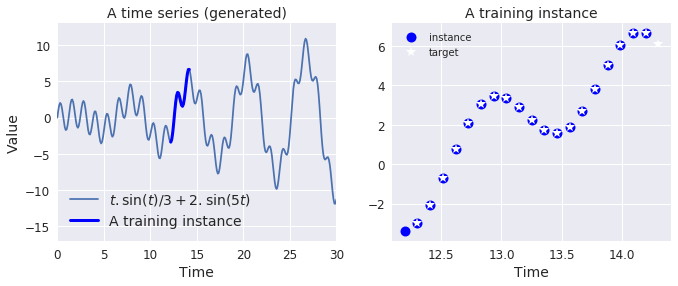

In [70]:
t = np.linspace(t_min, t_max, int((t_max - t_min) / resolution))

n_steps = 20
t_instance = np.linspace(12.2, 12.2 + resolution * (n_steps + 1), n_steps + 1)

plt.figure(figsize=(11,4))
plt.subplot(121)
plt.title("A time series (generated)", fontsize=14)
plt.plot(t, time_series(t), label=r"$t . \sin(t) / 3 + 2 . \sin(5t)$")
plt.plot(t_instance[:-1], time_series(t_instance[:-1]), "b-", linewidth=3, label="A training instance")
plt.legend(loc="lower left", fontsize=14)
plt.axis([0, 30, -17, 13])
plt.xlabel("Time")
plt.ylabel("Value")

plt.subplot(122)
plt.title("A training instance", fontsize=14)
plt.plot(t_instance[:-1], time_series(t_instance[:-1]), "bo", markersize=10, label="instance")
plt.plot(t_instance[1:], time_series(t_instance[1:]), "w*", markersize=10, label="target")
plt.legend(loc="upper left")
plt.xlabel("Time")

plt.show()

In [71]:
t_instance

array([12.2  , 12.305, 12.41 , 12.515, 12.62 , 12.725, 12.83 , 12.935,
       13.04 , 13.145, 13.25 , 13.355, 13.46 , 13.565, 13.67 , 13.775,
       13.88 , 13.985, 14.09 , 14.195, 14.3  ])

In [72]:
t_instance[1:]

array([12.305, 12.41 , 12.515, 12.62 , 12.725, 12.83 , 12.935, 13.04 ,
       13.145, 13.25 , 13.355, 13.46 , 13.565, 13.67 , 13.775, 13.88 ,
       13.985, 14.09 , 14.195, 14.3  ])

/usr/local/envs/py3env/lib/python3.5/site-packages/matplotlib/font_manager.py:1320: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


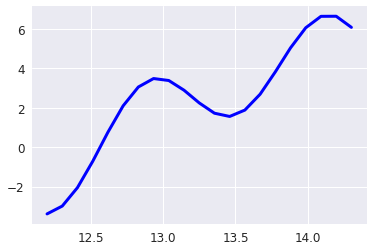

In [73]:
plt.plot(t_instance, time_series(t_instance), "b-", linewidth=3, label="A training instance")

In [74]:
seq1,seq2 = next_batch(5,3) # 5 instance , each step is 3
n_steps = 20
X_batch, y_batch = next_batch(1, n_steps) 

In [75]:
np.shape( np.c_[X_batch[0], y_batch[0]] )

(20, 2)

# Time series prediction: Using an OuputProjectionWrapper
Let's create the RNN. It will contain 100 recurrent neurons and we will unroll it over 20 time steps since each traiing instance will be 20 inputs long. Each input will contain only one feature (the value at that time). The targets are also sequences of 20 inputs, each containing a sigle value:

In [76]:
def trainingTimeSeries(init,training_op,loss,X,y,batch_size,n_iterations,n_steps,prjStep, folder="seq_rnn_ts"):
  saver = tf.train.Saver()
  statfolder=folder+"Stat"
  file_writer = tf.summary.FileWriter("./"+statfolder+"/RNN_time_series", tf.get_default_graph())
  mse_summary=tf.summary.scalar('mse', loss)
  with tf.Session() as sess:
      init.run()
      for iteration in range(n_iterations):
          X_batch, y_batch = next_batch(batch_size, n_steps,prjStep)
          #sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
          
          #if iteration % 100 == 0:
          #    saver.save(sess, "./"+folder+"/my_time_series_model{0}".format(iteration)) # not shown in the book
          #    mse = loss.eval(feed_dict={X: X_batch, y: y_batch})
          #    print(iteration, "\tMSE:", mse)
          #    saver.save(sess, "./"+folder+"/my_time_series_model_latest") # not shown in the book
          #else:
          #    mse_str = mse_summary.eval(feed_dict={X: X_batch, y: y_batch})
          #    file_writer.add_summary(mse_str, iteration)
          if iteration % 100 == 0:
              _, mse= sess.run([training_op, loss ], feed_dict={X: X_batch, y: y_batch})
              saver.save(sess, "./"+folder+"/my_time_series_model{0}".format(iteration)) # not shown in the book
              print(iteration, "\tMSE:", mse)
              saver.save(sess, "./"+folder+"/my_time_series_model_latest") # not shown in the book
          else:
              _, mse_str= sess.run([training_op, mse_summary ], feed_dict={X: X_batch, y: y_batch})
              file_writer.add_summary(mse_str, iteration)
      saver.save(sess, "./"+folder+"/my_time_series_model_latest") # not shown in the book

In [77]:
reset_graph()

n_steps = 20
n_inputs = 1
n_neurons = 100
n_outputs = 1

X = tf.placeholder(tf.float32, [None, n_steps, n_inputs])
y = tf.placeholder(tf.float32, [None, n_steps, n_outputs])

cell = tf.contrib.rnn.BasicRNNCell(num_units=n_neurons, activation=tf.nn.relu)
outputs, states = tf.nn.dynamic_rnn(cell, X, dtype=tf.float32)

At each time step we now have an output vector of size 100. But what we actually want is a single output value at each time step. The simplest solution is to wrap the cell in an `OutputProjectionWrapper`.

In [78]:
reset_graph()

n_steps = 20*2
n_inputs = 1
n_neurons = 100
n_outputs = 1

X = tf.placeholder(tf.float32, [None, n_steps, n_inputs])
y = tf.placeholder(tf.float32, [None, n_steps, n_outputs])

with tf.name_scope("rnn"):
  cell = tf.contrib.rnn.OutputProjectionWrapper(
      tf.contrib.rnn.BasicRNNCell(num_units=n_neurons, activation=tf.nn.relu),
      output_size=n_outputs)
  outputs, states = tf.nn.dynamic_rnn(cell, X, dtype=tf.float32)
  
  learning_rate = 0.001
with tf.name_scope("loss"):
  loss = tf.reduce_mean(tf.square(outputs - y)) # MSE

with tf.name_scope("training"):
  optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
  training_op = optimizer.minimize(loss)

init = tf.global_variables_initializer()

In [79]:
n_iterations = 1500
batch_size = 50
projectStep=5
Training=True

t_instance = np.linspace(12.2, 12.2 + resolution * (n_steps + projectStep), n_steps + projectStep)

if(Training):
  trainingTimeSeries(init,training_op,loss,X,y,batch_size,n_iterations,n_steps, projectStep)
else:
  with tf.Session() as sess:                          # not shown in the book
    saver.restore(sess, "./seq_rnn_ts/my_time_series_model_latest")   # not shown
    
    X_new = time_series(np.array(t_instance[:-1*projectStep].reshape(-1, n_steps, n_inputs)))
    y_pred = sess.run(outputs, feed_dict={X: X_new})

0 	MSE: 16.76216
100 	MSE: 3.0813532
200 	MSE: 2.0076456
300 	MSE: 1.8014512
400 	MSE: 1.2691817
500 	MSE: 1.283225
600 	MSE: 1.4480107
700 	MSE: 1.368414
800 	MSE: 1.1983418
900 	MSE: 1.287919
1000 	MSE: 1.008548
1100 	MSE: 1.1240304
1200 	MSE: 1.0478011
1300 	MSE: 1.0271035
1400 	MSE: 1.0168123


In [80]:
#show_graph(tf.get_default_graph())

In [81]:
if(not Training):
  plt.title("Testing the model", fontsize=14)
  plt.plot(t_instance[:-1*projectStep], time_series(t_instance[:-1*projectStep]), "bo", markersize=10, label="instance")
  plt.plot(t_instance[projectStep:], time_series(t_instance[projectStep:]), "w*", markersize=10, label="target")
  plt.plot(t_instance[projectStep:], y_pred[0,:,0], "r.", markersize=10, label="prediction")
  plt.legend(loc="upper left")
  plt.xlabel("Time")

  plt.show()

In [82]:
if(not Training):
  np.shape(y_pred)
  np.shape(t_instance)
  plt.title("Testing the model", fontsize=14)
  plt.plot(t_instance[:-1*projectStep], time_series(t_instance[:-1*projectStep]), "bo", markersize=10, label="instance")
  plt.plot(t_instance[projectStep:], time_series(t_instance[projectStep:]), "w*", markersize=10, label="target")
  plt.plot(t_instance[projectStep:], y_pred[0,:,0], "r.", markersize=10, label="prediction")
  plt.legend(loc="upper left")
  plt.xlabel("Time")

  plt.show()
  t_instance[:-1 * 2]
  next_batch(50, 20,2)

# Without using an OutputProjectionWrapper

OutputProjectWrapper is not the most efficient way of creating output.<br>
We would use a layer of neural network to produce our output instead.

![title](img/RNN_Predict.png)

In [83]:
def defineRNN_Seq(n_inputs,n_neurons,n_outputs,n_steps):
  X = tf.placeholder(tf.float32, [None, n_steps, n_inputs])
  y = tf.placeholder(tf.float32, [None, n_steps, n_outputs])

  with tf.name_scope("rnn"):
    cell = tf.contrib.rnn.BasicRNNCell(num_units=n_neurons, activation=tf.nn.relu)
    rnn_outputs, states = tf.nn.dynamic_rnn(cell, X, dtype=tf.float32)
    stacked_rnn_outputs = tf.reshape(rnn_outputs, [-1, n_neurons])
    stacked_outputs = tf.layers.dense(stacked_rnn_outputs, n_outputs)
    outputs = tf.reshape(stacked_outputs, [-1, n_steps, n_outputs])
    
  with tf.name_scope("loss"):
    loss = tf.reduce_mean(tf.square(outputs - y)) # MSE

  with tf.name_scope("training"):
    learning_rate = 0.001
    optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
    training_op = optimizer.minimize(loss)

  init = tf.global_variables_initializer()
  return init,training_op,loss,X,y,outputs

In [84]:
reset_graph()
n_inputs = 1
n_neurons = 100
n_outputs = 1
n_steps = 20
init,training_op,loss,X,y,outputs=defineRNN_Seq(n_inputs,n_neurons,n_outputs,n_steps)
n_iterations = 1500*2
batch_size = 50
projectStep=5
Training=True

t_instance = np.linspace(12.2, 12.2 + resolution * (n_steps + projectStep), n_steps + projectStep)

if(Training):
  trainingTimeSeries(init,training_op,loss,X,y,batch_size,n_iterations,n_steps, projectStep)
  
else:
  saver = tf.train.Saver()
  with tf.Session() as sess:                          # not shown in the book
    
    saver.restore(sess, "./seq_rnn_ts/my_time_series_model_latest")   # not shown
    
    X_new = time_series(np.array(t_instance[:-1*projectStep].reshape(-1, n_steps, n_inputs)))
    print(sess.run(tf.shape(X), feed_dict={X: X_new}))
    y_pred = sess.run(outputs, feed_dict={X: X_new})

0 	MSE: 14.651644
100 	MSE: 5.309462
200 	MSE: 4.50422
300 	MSE: 3.1868863
400 	MSE: 2.3629606
500 	MSE: 2.2992463
600 	MSE: 2.5849922
700 	MSE: 2.333883
800 	MSE: 2.1230643
900 	MSE: 2.207485
1000 	MSE: 2.0384445
1100 	MSE: 2.507852
1200 	MSE: 1.9282405
1300 	MSE: 1.8374633
1400 	MSE: 1.6013063
1500 	MSE: 2.0643847
1600 	MSE: 1.8413237
1700 	MSE: 1.9523469
1800 	MSE: 1.670979
1900 	MSE: 1.5504924
2000 	MSE: 1.6696647
2100 	MSE: 1.5773753
2200 	MSE: 1.7818664
2300 	MSE: 1.7043129
2400 	MSE: 1.5225862
2500 	MSE: 1.4148164
2600 	MSE: 1.4002029
2700 	MSE: 1.2575605
2800 	MSE: 2.020423
2900 	MSE: 1.622005


In [85]:
reset_graph()
init,training_op,loss,X,y,outputs=defineRNN_Seq(n_inputs,n_neurons,n_outputs,n_steps)
saver = tf.train.Saver()
with tf.Session() as sess:                          # not shown in the book
    
    saver.restore(sess, "./seq_rnn_ts/my_time_series_model_latest")   # not shown
    
    X_new = time_series(np.array(t_instance[:-1*projectStep].reshape(-1, n_steps, n_inputs)))
    print(sess.run(tf.shape(X), feed_dict={X: X_new}))
    y_pred = sess.run(outputs, feed_dict={X: X_new})
    

INFO:tensorflow:Restoring parameters from ./seq_rnn_ts/my_time_series_model_latest
[ 1 20  1]


In [86]:
#show_graph(tf.get_default_graph())


/usr/local/envs/py3env/lib/python3.5/site-packages/matplotlib/font_manager.py:1320: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


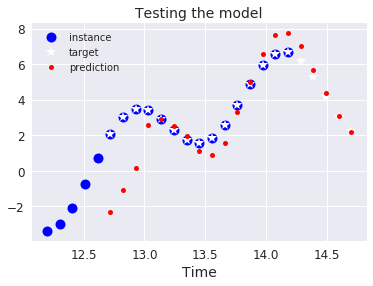

In [87]:
Training=False
if(not Training):
  np.shape(y_pred)
  np.shape(t_instance)
  plt.title("Testing the model", fontsize=14)
  plt.plot(t_instance[:-1*projectStep], time_series(t_instance[:-1*projectStep]), "bo", markersize=10, label="instance")
  plt.plot(t_instance[projectStep:], time_series(t_instance[projectStep:]), "w*", markersize=10, label="target")
  plt.plot(t_instance[projectStep:], y_pred[0,:,0], "r.", markersize=10, label="prediction")
  plt.legend(loc="upper left")
  plt.xlabel("Time")

  plt.show()
  t_instance[:-1 * 2]
  next_batch(50, 20,2)

# Generating a creative new sequence¶

Before running creative sequence
We should change the projectstep=1 to mininize the predicted error
Otherwise, the output will saturate or vanish

In [88]:
reset_graph()
n_inputs = 1
n_neurons = 100
n_outputs = 1
n_steps = 20*2
init,training_op,loss,X,y,outputs=defineRNN_Seq(n_inputs,n_neurons,n_outputs,n_steps)

n_iterations = 1500
batch_size = 50
projectStep=1
Training=True
n_steps=20*2

t_instance = np.linspace(12.2, 12.2 + resolution * (n_steps + projectStep), n_steps + projectStep)

if(Training):
  trainingTimeSeries(init,training_op,loss,X,y,batch_size,n_iterations,n_steps, projectStep)

0 	MSE: 14.892215
100 	MSE: 0.36473548
200 	MSE: 0.19569127
300 	MSE: 0.08254086
400 	MSE: 0.056042198
500 	MSE: 0.035784762
600 	MSE: 0.032625742
700 	MSE: 0.02657033
800 	MSE: 0.022683877
900 	MSE: 0.028391132
1000 	MSE: 0.021918282
1100 	MSE: 0.023634272
1200 	MSE: 0.018564591
1300 	MSE: 0.023249038
1400 	MSE: 0.024167003


In [89]:
reset_graph()
init,training_op,loss,X,y,outputs=defineRNN_Seq(n_inputs,n_neurons,n_outputs,n_steps)
saver = tf.train.Saver()
with tf.Session() as sess:
    saver.restore(sess, "./seq_rnn_ts/my_time_series_model_latest")

    sequence1 = [0. for i in range(n_steps)]
    for iteration in range(len(t) - n_steps):
        X_batch = np.array(sequence1[-n_steps:]).reshape(1, n_steps, 1)
        y_pred = sess.run(outputs, feed_dict={X: X_batch})
        sequence1.append(y_pred[0, -1, 0])

    sequence2 = [time_series(i * resolution + t_min + (t_max-t_min/3)) for i in range(n_steps)]
    for iteration in range(len(t) - n_steps):
        X_batch = np.array(sequence2[-n_steps:]).reshape(1, n_steps, 1)
        y_pred = sess.run(outputs, feed_dict={X: X_batch})
        sequence2.append(y_pred[0, -1, 0])

INFO:tensorflow:Restoring parameters from ./seq_rnn_ts/my_time_series_model_latest


/usr/local/envs/py3env/lib/python3.5/site-packages/matplotlib/font_manager.py:1320: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


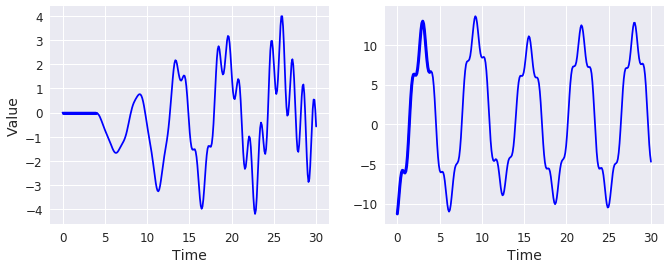

In [90]:
plt.figure(figsize=(11,4))
plt.subplot(121)
plt.plot(t, sequence1, "b-")
plt.plot(t[:n_steps], sequence1[:n_steps], "b-", linewidth=3)
plt.xlabel("Time")
plt.ylabel("Value")

plt.subplot(122)
plt.plot(t, sequence2, "b-")
plt.plot(t[:n_steps], sequence2[:n_steps], "b-", linewidth=3)
plt.xlabel("Time")
plt.show()

# Deep RNN <br>
# MultiRNNCell

In [91]:
def defineDeepRNN_Seq(n_inputs,n_neurons,n_outputs,n_steps,n_layers):
  
  X = tf.placeholder(tf.float32, [None, n_steps, n_inputs])
  y = tf.placeholder(tf.float32, [None, n_steps, n_outputs])

  with tf.name_scope("multi-rnn"):
    cells = [tf.contrib.rnn.BasicRNNCell(num_units=n_neurons, activation=tf.nn.relu)
         for layer in range(n_layers)]
    
    multi_layer_cell = tf.contrib.rnn.MultiRNNCell(cells)
    rnn_outputs, states = tf.nn.dynamic_rnn(multi_layer_cell, X, dtype=tf.float32)
    
  with tf.name_scope("stack-output"):
    stacked_rnn_outputs = tf.reshape(rnn_outputs, [-1, n_neurons])
    stacked_outputs = tf.layers.dense(stacked_rnn_outputs, n_outputs)
    outputs = tf.reshape(stacked_outputs, [-1, n_steps, n_outputs])

  with tf.name_scope("loss"):
    loss = tf.reduce_mean(tf.square(outputs - y)) # MSE

  with tf.name_scope("training"):
    learning_rate = 0.001
    optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
    training_op = optimizer.minimize(loss)

  init = tf.global_variables_initializer()
  return init,training_op,loss,X,y,outputs

In [92]:
n_inputs = 1
n_neurons = 100
n_layers = 3
n_steps = 20
n_outputs = 1
projectStep=5
reset_graph()
init,training_op,loss,X,y,outputs=defineDeepRNN_Seq(n_inputs,n_neurons,n_outputs,n_steps,n_layers)

n_iterations = 1500*2
batch_size = 50
train_keep_prob = 0.5



t_instance = np.linspace(12.2, 12.2 + resolution * (n_steps + projectStep), n_steps + projectStep)

trainingTimeSeries(init,training_op,loss,X,y,batch_size,n_iterations,n_steps, projectStep,"DeepRNN")


0 	MSE: 14.733511
100 	MSE: 2.5463712
200 	MSE: 2.0621839
300 	MSE: 1.4846685
400 	MSE: 1.1933783
500 	MSE: 1.1523839
600 	MSE: 1.272857
700 	MSE: 1.3529918
800 	MSE: 1.111061
900 	MSE: 1.2913547
1000 	MSE: 1.171259
1100 	MSE: 1.4087777
1200 	MSE: 1.0501363
1300 	MSE: 1.0556656
1400 	MSE: 0.87363744
1500 	MSE: 1.1249522
1600 	MSE: 1.114592
1700 	MSE: 1.0748209
1800 	MSE: 0.86219895
1900 	MSE: 0.9536355
2000 	MSE: 1.0250541
2100 	MSE: 0.79749656
2200 	MSE: 1.2042289
2300 	MSE: 1.112924
2400 	MSE: 0.84841466
2500 	MSE: 0.7726139
2600 	MSE: 0.929301
2700 	MSE: 0.7923875
2800 	MSE: 1.283823
2900 	MSE: 0.8969332


In [93]:
reset_graph()
folder="DeepRNN"
init,training_op,loss,X,y,outputs=defineDeepRNN_Seq(n_inputs,n_neurons,n_outputs,n_steps,n_layers)
saver = tf.train.Saver()
with tf.Session() as sess:                          # not shown in the book
    
    saver.restore(sess, "./"+folder+"/my_time_series_model_latest")   # not shown
    
    X_new = time_series(np.array(t_instance[:-1*projectStep].reshape(-1, n_steps, n_inputs)))
    print(sess.run(tf.shape(X), feed_dict={X: X_new}))
    y_pred = sess.run(outputs, feed_dict={X: X_new})

INFO:tensorflow:Restoring parameters from ./DeepRNN/my_time_series_model_latest
[ 1 20  1]


/usr/local/envs/py3env/lib/python3.5/site-packages/matplotlib/font_manager.py:1320: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


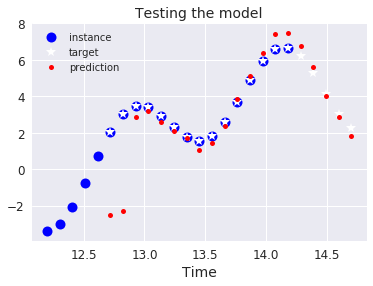

In [94]:
np.shape(y_pred)
np.shape(t_instance)
plt.title("Testing the model", fontsize=14)
plt.plot(t_instance[:-1*projectStep], time_series(t_instance[:-1*projectStep]), "bo", markersize=10, label="instance")
plt.plot(t_instance[projectStep:], time_series(t_instance[projectStep:]), "w*", markersize=10, label="target")
plt.plot(t_instance[projectStep:], y_pred[0,:,0], "r.", markersize=10, label="prediction")
plt.legend(loc="upper left")
plt.xlabel("Time")

plt.show()


# Training with dropout

In [95]:
def trainingTimeSeriesWithDropout(init,training_op,loss,X,y,keep_prob,batch_size,n_iterations,n_steps,prjStep,train_keep_prob=1.0, folder="seq_rnn_ts"):
  saver = tf.train.Saver()
  statfolder=folder+"Stat"
  file_writer = tf.summary.FileWriter("./"+statfolder+"/RNN_time_series", tf.get_default_graph())
  mse_summary=tf.summary.scalar('mse', loss)
  with tf.Session() as sess:
      init.run()
      for iteration in range(n_iterations):
          X_batch, y_batch = next_batch(batch_size, n_steps,prjStep)
          
          
          if iteration % 100 == 0:
              _, mse= sess.run([training_op, loss ], feed_dict={X: X_batch, y: y_batch, keep_prob: train_keep_prob})
              saver.save(sess, "./"+folder+"/my_time_series_model{0}".format(iteration)) # not shown in the book
              print(iteration, "\tMSE:", mse)
              saver.save(sess, "./"+folder+"/my_time_series_model_latest") # not shown in the book
          else:
              _, mse_str= sess.run([training_op, mse_summary ], feed_dict={X: X_batch, y: y_batch, keep_prob: train_keep_prob})
              file_writer.add_summary(mse_str, iteration)
      saver.save(sess, "./"+folder+"/my_time_series_model_latest") # not shown in the book

In [96]:
def defineDeepRNNwithDropOff_Seq(n_inputs,n_neurons,n_outputs,n_steps,n_layers):
  
  X = tf.placeholder(tf.float32, [None, n_steps, n_inputs])
  y = tf.placeholder(tf.float32, [None, n_steps, n_outputs])
  keep_prob = tf.placeholder_with_default(1.0, [])
  
  with tf.name_scope("multi-rnn"):
    cells = [tf.contrib.rnn.BasicRNNCell(num_units=n_neurons, activation=tf.nn.relu)
         for layer in range(n_layers)]
    
    cells_drop = [tf.contrib.rnn.DropoutWrapper(cell, input_keep_prob=keep_prob)
              for cell in cells]
    
    multi_layer_cell = tf.contrib.rnn.MultiRNNCell(cells_drop)
    rnn_outputs, states = tf.nn.dynamic_rnn(multi_layer_cell, X, dtype=tf.float32)
    
  with tf.name_scope("stack-output"):
    stacked_rnn_outputs = tf.reshape(rnn_outputs, [-1, n_neurons])
    stacked_outputs = tf.layers.dense(stacked_rnn_outputs, n_outputs)
    outputs = tf.reshape(stacked_outputs, [-1, n_steps, n_outputs])

  with tf.name_scope("loss"):
    loss = tf.reduce_mean(tf.square(outputs - y)) # MSE

  with tf.name_scope("training"):
    learning_rate = 0.001
    optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
    training_op = optimizer.minimize(loss)

  init = tf.global_variables_initializer()
  return init,training_op,loss,X,y,outputs,keep_prob

In [97]:
n_inputs = 1
n_neurons = 100
n_layers = 3
n_steps = 20
n_outputs = 1
projectStep=5
reset_graph()
init,training_op,loss,X,y,outputs,keep_prob=defineDeepRNNwithDropOff_Seq(n_inputs,n_neurons,n_outputs,n_steps,n_layers)

n_iterations = 1500*2
batch_size = 50
train_keep_prob = 0.5


folder="DeepRNNDropout"
t_instance = np.linspace(12.2, 12.2 + resolution * (n_steps + projectStep), n_steps + projectStep)

trainingTimeSeriesWithDropout(init,training_op,loss,X,y,keep_prob,batch_size,n_iterations,n_steps, projectStep,0.5,folder)

0 	MSE: 14.968769
100 	MSE: 12.024711
200 	MSE: 9.648569
300 	MSE: 8.689868
400 	MSE: 7.5120897
500 	MSE: 7.403696
600 	MSE: 8.5329685
700 	MSE: 7.3764396
800 	MSE: 6.815543
900 	MSE: 8.165207
1000 	MSE: 6.82006
1100 	MSE: 7.6499963
1200 	MSE: 6.427146
1300 	MSE: 6.938668
1400 	MSE: 5.740614
1500 	MSE: 7.843949
1600 	MSE: 6.727527
1700 	MSE: 6.358778
1800 	MSE: 4.94771
1900 	MSE: 5.977087
2000 	MSE: 5.8768253
2100 	MSE: 6.829656
2200 	MSE: 5.7508397
2300 	MSE: 5.511374
2400 	MSE: 5.210814
2500 	MSE: 5.4998136
2600 	MSE: 5.5238624
2700 	MSE: 5.2941356
2800 	MSE: 7.041564
2900 	MSE: 5.2019453


In [98]:
reset_graph()

init,training_op,loss,X,y,outputs=defineDeepRNN_Seq(n_inputs,n_neurons,n_outputs,n_steps,n_layers)
saver = tf.train.Saver()
with tf.Session() as sess:                          # not shown in the book
    
    saver.restore(sess, "./"+folder+"/my_time_series_model_latest")   # not shown
    
    X_new = time_series(np.array(t_instance[:-1*projectStep].reshape(-1, n_steps, n_inputs)))
    print(sess.run(tf.shape(X), feed_dict={X: X_new}))
    y_pred = sess.run(outputs, feed_dict={X: X_new})

INFO:tensorflow:Restoring parameters from ./DeepRNNDropout/my_time_series_model_latest
[ 1 20  1]


/usr/local/envs/py3env/lib/python3.5/site-packages/matplotlib/font_manager.py:1320: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


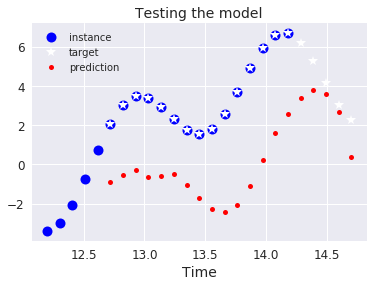

In [99]:
np.shape(y_pred)
np.shape(t_instance)
plt.title("Testing the model", fontsize=14)
plt.plot(t_instance[:-1*projectStep], time_series(t_instance[:-1*projectStep]), "bo", markersize=10, label="instance")
plt.plot(t_instance[projectStep:], time_series(t_instance[projectStep:]), "w*", markersize=10, label="target")
plt.plot(t_instance[projectStep:], y_pred[0,:,0], "r.", markersize=10, label="prediction")
plt.legend(loc="upper left")
plt.xlabel("Time")

plt.show()

# LTSM  cell

![title](img/LTSMCell.png)

In [8]:
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("/tmp/data/")
X_test = mnist.test.images.reshape((-1, n_steps, n_inputs))
y_test = mnist.test.labels

Extracting /tmp/data/train-images-idx3-ubyte.gz
Extracting /tmp/data/train-labels-idx1-ubyte.gz
Extracting /tmp/data/t10k-images-idx3-ubyte.gz
Extracting /tmp/data/t10k-labels-idx1-ubyte.gz


In [9]:
reset_graph()

#lstm_cell = tf.contrib.rnn.BasicLSTMCell(num_units=n_neurons)
n_steps = 28
n_inputs = 28
n_neurons = 150
n_outputs = 10
n_layers = 3

learning_rate = 0.001

X = tf.placeholder(tf.float32, [None, n_steps, n_inputs])
y = tf.placeholder(tf.int32, [None])

lstm_cells = [tf.contrib.rnn.BasicLSTMCell(num_units=n_neurons)
              for layer in range(n_layers)]
multi_cell = tf.contrib.rnn.MultiRNNCell(lstm_cells)
outputs, states = tf.nn.dynamic_rnn(multi_cell, X, dtype=tf.float32)
top_layer_h_state = states[-1][1]
logits = tf.layers.dense(top_layer_h_state, n_outputs, name="softmax")
xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)
loss = tf.reduce_mean(xentropy, name="loss")
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
training_op = optimizer.minimize(loss)
correct = tf.nn.in_top_k(logits, y, 1)
accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))
    
init = tf.global_variables_initializer()

In [ ]:
n_epochs = 10
batch_size = 150

with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        for iteration in range(mnist.train.num_examples // batch_size):
            X_batch, y_batch = mnist.train.next_batch(batch_size)
            X_batch = X_batch.reshape((batch_size, n_steps, n_inputs))
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        acc_train = accuracy.eval(feed_dict={X: X_batch, y: y_batch})
        acc_test = accuracy.eval(feed_dict={X: X_test, y: y_test})
        print("Epoch", epoch, "Train accuracy =", acc_train, "Test accuracy =", acc_test)

Epoch 0 Train accuracy = 0.98 Test accuracy = 0.9474
Epoch 1 Train accuracy = 0.97333336 Test accuracy = 0.9687
Epoch 2 Train accuracy = 0.97333336 Test accuracy = 0.9761
Epoch 3 Train accuracy = 0.97333336 Test accuracy = 0.9772
Epoch 4 Train accuracy = 0.97333336 Test accuracy = 0.98
Epoch 5 Train accuracy = 1.0 Test accuracy = 0.9849
Epoch 6 Train accuracy = 0.99333334 Test accuracy = 0.9865
Epoch 7 Train accuracy = 0.99333334 Test accuracy = 0.9865
Epoch 8 Train accuracy = 0.9866667 Test accuracy = 0.9877
